In [14]:
import os
import glob
import numpy as np
import rasterio
import netCDF4 as nc
from datetime import datetime
import argparse
from tqdm import tqdm

def geotiff_to_netcdf(input_dir, output_dir, data_type='region'):
    """
    将GeoTIFF文件转换为NetCDF格式
    
    参数:
    input_dir: 包含GeoTIFF文件的输入目录
    output_dir: 输出NetCDF文件的目录
    data_type: 数据类型，'region' 或 'grid'
    """
    # 创建输出目录
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 获取所有GeoTIFF文件
    if data_type == 'region':
        tiff_files = glob.glob(os.path.join(input_dir, "Glacier_Elevation_Change_*.tif"))
        error_files = glob.glob(os.path.join(input_dir, "Glacier_Elevation_Change_Error_*.tif"))
        
        # 处理主要海拔变化数据
        for tiff_file in tqdm(tiff_files, desc="Processing elevation change files"):
            # 从文件名提取区域名称
            region_name = os.path.basename(tiff_file).replace("Glacier_Elevation_Change_", "").replace(".tif", "")
            convert_single_file(tiff_file, os.path.join(output_dir, f"glacier_elevation_change_{region_name}.nc"), "elevation_change")
        
        # 处理误差数据
        for error_file in tqdm(error_files, desc="Processing error files"):
            region_name = os.path.basename(error_file).replace("Glacier_Elevation_Change_Error_", "").replace(".tif", "")
            convert_single_file(error_file, os.path.join(output_dir, f"glacier_elevation_change_error_{region_name}.nc"), "elevation_change_error")
    
    elif data_type == 'grid':
        grid_files = glob.glob(os.path.join(input_dir, "Glacier_Elevation_Change_grid_*.tif"))
        
        for grid_file in tqdm(grid_files, desc="Processing grid files"):
            # 从文件名提取网格信息
            grid_name = os.path.basename(grid_file).replace("Glacier_Elevation_Change_", "").replace(".tif", "")
            convert_single_file(grid_file, os.path.join(output_dir, f"glacier_elevation_change_{grid_name}.nc"), "elevation_change")

def convert_single_file(tiff_path, nc_path, var_name):
    """
    将单个GeoTIFF文件转换为NetCDF格式
    
    参数:
    tiff_path: GeoTIFF文件路径
    nc_path: 输出NetCDF文件路径
    var_name: 变量名称
    """
    # 读取GeoTIFF文件
    with rasterio.open(tiff_path) as src:
        # 获取数据
        data = src.read(1)  # 读取第一个波段
        
        # 处理缺失值
        nodata = src.nodata
        if nodata is not None:
            data = np.where(data == nodata, np.nan, data)
        
        # 获取地理参考信息
        transform = src.transform
        width = src.width
        height = src.height
        
        # 计算经纬度坐标
        lons = np.zeros(width)
        lats = np.zeros(height)
        
        for i in range(width):
            x, _ = transform * (i, 0)
            lons[i] = x
        
        for j in range(height):
            _, y = transform * (0, j)
            lats[j] = y
    
    # 创建NetCDF文件
    with nc.Dataset(nc_path, 'w', format='NETCDF4') as dst:
        # 创建维度
        dst.createDimension('lat', height)
        dst.createDimension('lon', width)
        
        # 创建变量
        latitudes = dst.createVariable('latitude', np.float32, ('lat',))
        longitudes = dst.createVariable('longitude', np.float32, ('lon',))
        values = dst.createVariable(var_name, np.float32, ('lat', 'lon'), fill_value=np.nan)
        
        # 写入数据
        latitudes[:] = lats
        longitudes[:] = lons
        values[:, :] = data
        
        # 添加属性
        dst.description = f"Glacier {var_name} data converted from GeoTIFF"
        dst.history = f"Created on {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')}"
        dst.source = os.path.basename(tiff_path)
        
        latitudes.units = "degrees_north"
        latitudes.long_name = "Latitude"
        longitudes.units = "degrees_east"
        longitudes.long_name = "Longitude"
        
        if "error" in var_name.lower():
            values.units = "meters/year"
            values.long_name = "Elevation change error"
        else:
            values.units = "meters/year"
            values.long_name = "Elevation change rate"
        
        print(f"Converted {tiff_path} to {nc_path}")

if __name__ == "__main__":
    input_path = 'D:\Data/global_glacier_change/'
    output_path = 'D:\CSSP\out_data\GLOBAL/'
    region_type = 'region'  # 'region' or 'grid'
    geotiff_to_netcdf(input_path, output_path, region_type)

Processing elevation change files:   0%|          | 0/11 [00:11<?, ?it/s]


KeyboardInterrupt: 

成功使用 latin1 编码读取文件
已将列 X 重命名为 X，Y 重命名为 Y
原始数据类型:
X       float64
Y       float64
Îó²î    float64
dtype: object
转换后数据类型:
X       float64
Y       float64
Îó²î    float64
dtype: object

数据基本统计:
                  X           Y          Îó²î
count  3.070000e+02  307.000000  3.070000e+02
mean  -5.121150e-02   -0.051211 -9.120521e-10
std    4.031129e-16    0.405324  4.053245e-01
min   -5.121150e-02   -4.149616 -1.241930e+00
25%   -5.121150e-02   -0.058995 -8.095443e-02
50%   -5.121150e-02   -0.015244 -3.596739e-02
75%   -5.121150e-02    0.029743  7.783434e-03
max   -5.121150e-02    1.190719  4.098405e+00

检测到的异常值数量: 23
清洗后的数据点数量: 284

模型性能比较:
线性拟合: R²=0.0000, RMSE=0.0766
二次多项式拟合: R²=0.0000, RMSE=0.0766
三次多项式拟合: R²=0.0000, RMSE=0.0766
稳健拟合: R²=-0.0002, RMSE=0.0766

拟合方程:
线性拟合: Y = 0.000000 * X + -0.008557
二次多项式拟合: Y = -0.000053 * X² + 0.005591 * X + -0.008271
三次多项式拟合: Y = 0.000005 * X³ + -0.000052 * X² + 0.005466 * X + -0.008277
稳健拟合: Y = 0.000489 * X + -0.009558

根据R²值，最佳模型是: 线性拟合 (R²=0.0000)

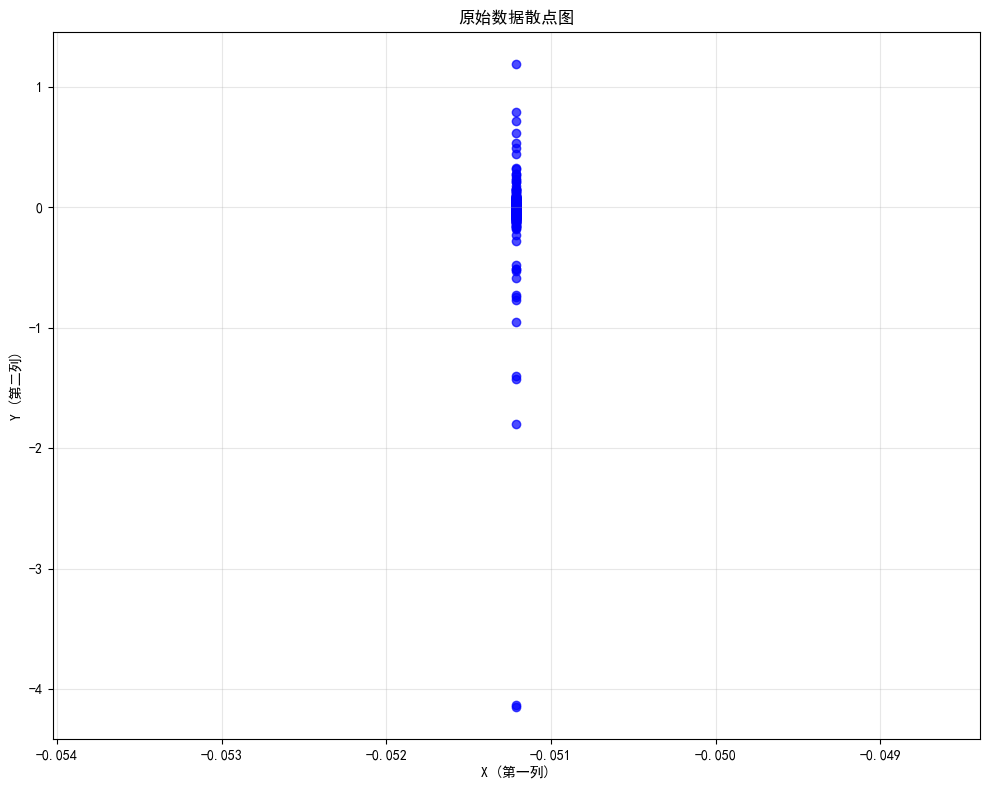

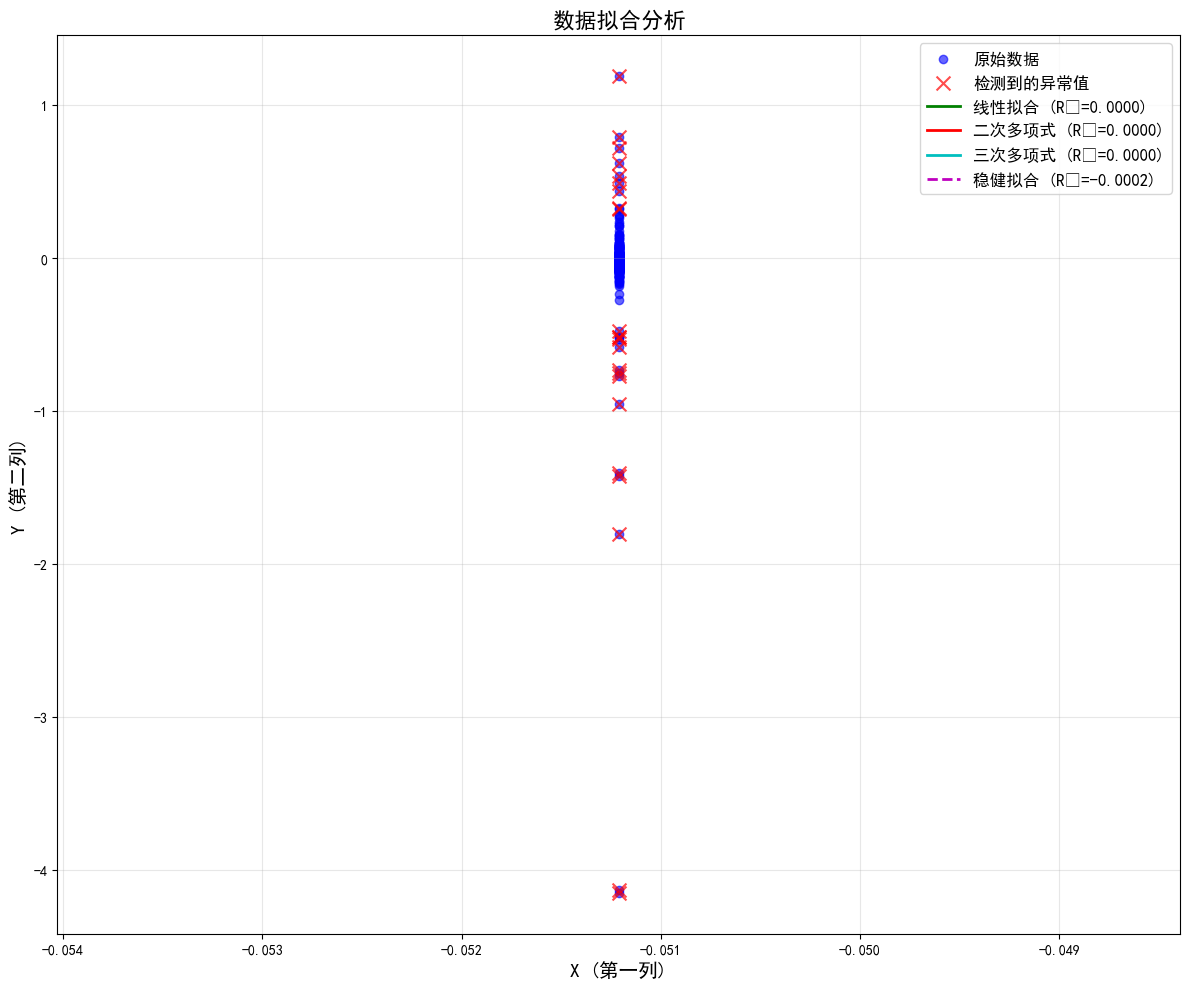

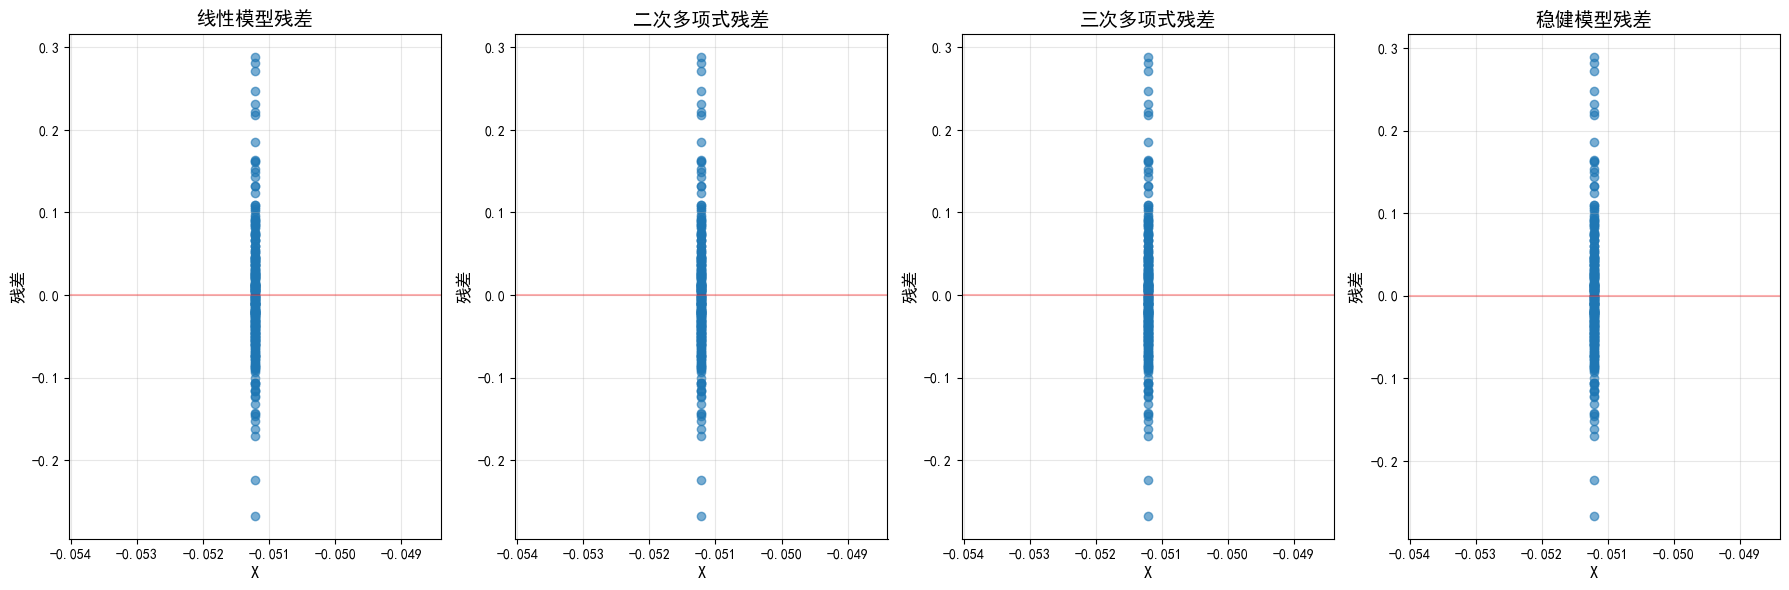

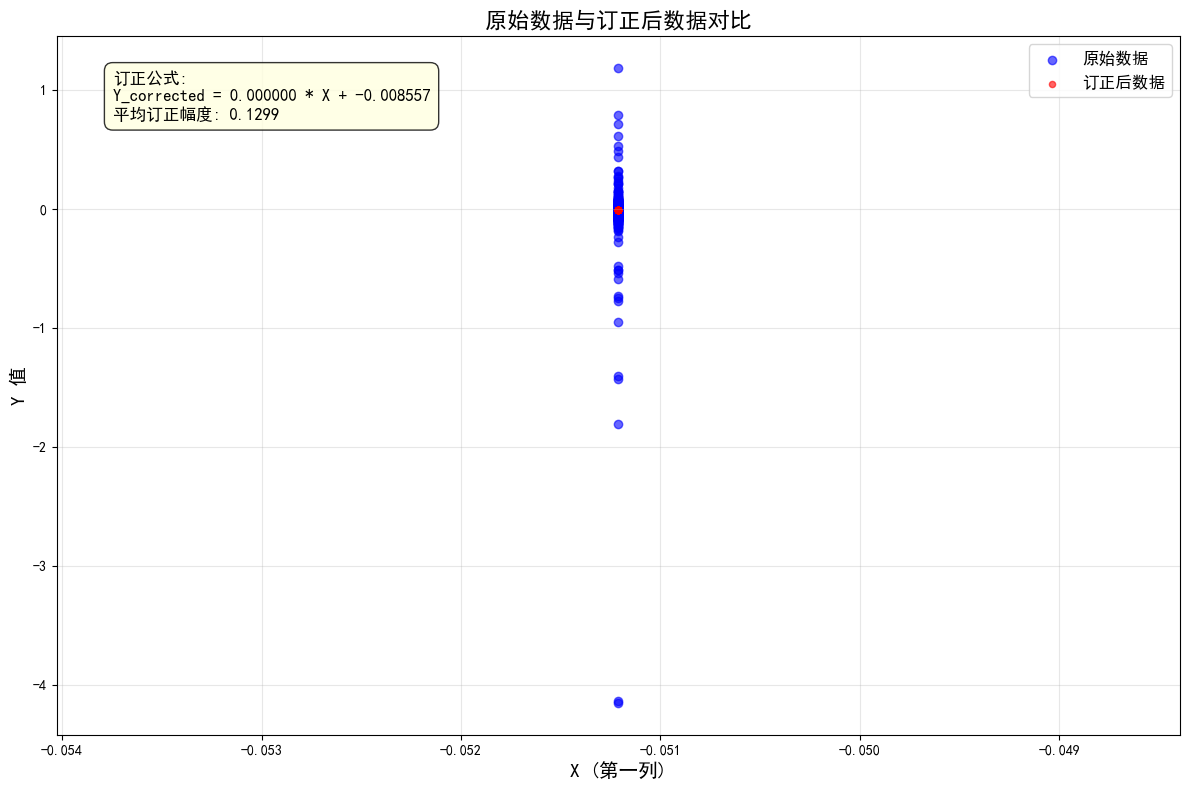

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 读取CSV数据并处理编码问题
try:
    # 尝试使用不同编码读取文件
    encodings = ['latin1', 'gbk', 'cp1252', 'iso-8859-1', 'utf-8']
    for encoding in encodings:
        try:
            file_path = r"D:\CSSP\regional_scientific_analysis_ref2sim\Iceland\Iceland_1991_data_points_ref2sim.csv"
            df = pd.read_csv(file_path, header=0, encoding=encoding)
            print(f"成功使用 {encoding} 编码读取文件")
            break
        except UnicodeDecodeError:
            continue
        except Exception as e:
            print(f"尝试 {encoding} 编码时出错: {e}")
            continue
    else:  # 如果所有编码都失败
        print("所有编码尝试都失败，创建示例数据进行演示")
        # 创建示例数据
        x = np.linspace(-3, 13, 100)
        y = 0.05 * x**2 + 0.8 * x + 0.2 + np.random.normal(0, 0.3, 100)
        df = pd.DataFrame({'校正后模拟值': x, '插值观测值': y})
except Exception as e:
    print(f"读取文件时出错: {e}")
    # 创建示例数据
    x = np.linspace(-3, 13, 100)
    y = 0.05 * x**2 + 0.8 * x + 0.2 + np.random.normal(0, 0.3, 100)
    df = pd.DataFrame({'校正后模拟值': x, '插值观测值': y})

# 2. 重命名列以确保一致性
if '校正后模拟值' in df.columns and '插值观测值' in df.columns:
    df.rename(columns={'校正后模拟值': 'X', '插值观测值': 'Y'}, inplace=True)
elif df.shape[1] >= 2:
    # 如果有至少2列但名称不匹配预期，重命名前两列
    df_columns = df.columns.tolist()
    df.rename(columns={df_columns[0]: 'X', df_columns[1]: 'Y'}, inplace=True)
    print(f"已将列 {df_columns[0]} 重命名为 X，{df_columns[1]} 重命名为 Y")

# 3. 确保数据类型为数值型
print("原始数据类型:")
print(df.dtypes)

try:
    df['X'] = pd.to_numeric(df['X'], errors='coerce')
    df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
    
    # 删除转换后的NaN值
    df.dropna(inplace=True)
    
    print("转换后数据类型:")
    print(df.dtypes)
except Exception as e:
    print(f"转换数据类型时出错: {e}")

# 4. 数据统计分析
print("\n数据基本统计:")
print(df.describe())

# 5. 绘制初始散点图
plt.figure(figsize=(10, 8))
plt.scatter(df['X'], df['Y'], alpha=0.7, color='blue')
plt.title('原始数据散点图')
plt.xlabel('X (第一列)')
plt.ylabel('Y (第二列)')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 6. 异常值检测和处理
Q1_x = df['X'].quantile(0.25)
Q3_x = df['X'].quantile(0.75)
IQR_x = Q3_x - Q1_x
lower_bound_x = Q1_x - 3 * IQR_x  # 使用3倍IQR，更宽松的标准
upper_bound_x = Q3_x + 3 * IQR_x

Q1_y = df['Y'].quantile(0.25)
Q3_y = df['Y'].quantile(0.75)
IQR_y = Q3_y - Q1_y
lower_bound_y = Q1_y - 3 * IQR_y
upper_bound_y = Q3_y + 3 * IQR_y

outliers = df[(df['X'] < lower_bound_x) | (df['X'] > upper_bound_x) | 
              (df['Y'] < lower_bound_y) | (df['Y'] > upper_bound_y)]

# 清洗后的数据（移除异常值）
df_cleaned = df[~df.index.isin(outliers.index)]

print(f"\n检测到的异常值数量: {len(outliers)}")
print(f"清洗后的数据点数量: {len(df_cleaned)}")

# 7. 拟合模型
# 线性拟合
model_linear = LinearRegression()
model_linear.fit(df_cleaned[['X']], df_cleaned['Y'])

# 多项式拟合（二次）
model_poly2 = make_pipeline(PolynomialFeatures(2), LinearRegression())
model_poly2.fit(df_cleaned[['X']], df_cleaned['Y'])

# 多项式拟合（三次）
model_poly3 = make_pipeline(PolynomialFeatures(3), LinearRegression())
model_poly3.fit(df_cleaned[['X']], df_cleaned['Y'])

# 稳健拟合（对异常值不敏感）
try:
    model_robust = TheilSenRegressor(random_state=42, max_iter=300, max_subpopulation=10000)
    model_robust.fit(df_cleaned[['X']], df_cleaned['Y'])
    robust_success = True
except Exception as e:
    print(f"稳健拟合失败: {e}")
    robust_success = False

# 8. 计算模型性能
# 准备预测数据
X_range = np.linspace(df['X'].min(), df['X'].max(), 100).reshape(-1, 1)
y_pred_linear = model_linear.predict(X_range)
y_pred_poly2 = model_poly2.predict(X_range)
y_pred_poly3 = model_poly3.predict(X_range)
if robust_success:
    y_pred_robust = model_robust.predict(X_range)

# 计算模型指标
r2_linear = r2_score(df_cleaned['Y'], model_linear.predict(df_cleaned[['X']]))
rmse_linear = np.sqrt(mean_squared_error(df_cleaned['Y'], model_linear.predict(df_cleaned[['X']])))

r2_poly2 = r2_score(df_cleaned['Y'], model_poly2.predict(df_cleaned[['X']]))
rmse_poly2 = np.sqrt(mean_squared_error(df_cleaned['Y'], model_poly2.predict(df_cleaned[['X']])))

r2_poly3 = r2_score(df_cleaned['Y'], model_poly3.predict(df_cleaned[['X']]))
rmse_poly3 = np.sqrt(mean_squared_error(df_cleaned['Y'], model_poly3.predict(df_cleaned[['X']])))

if robust_success:
    r2_robust = r2_score(df_cleaned['Y'], model_robust.predict(df_cleaned[['X']]))
    rmse_robust = np.sqrt(mean_squared_error(df_cleaned['Y'], model_robust.predict(df_cleaned[['X']])))

# 9. 模型参数与性能评估
print("\n模型性能比较:")
print(f"线性拟合: R²={r2_linear:.4f}, RMSE={rmse_linear:.4f}")
print(f"二次多项式拟合: R²={r2_poly2:.4f}, RMSE={rmse_poly2:.4f}")
print(f"三次多项式拟合: R²={r2_poly3:.4f}, RMSE={rmse_poly3:.4f}")
if robust_success:
    print(f"稳健拟合: R²={r2_robust:.4f}, RMSE={rmse_robust:.4f}")

# 获取模型参数
linear_coef = model_linear.coef_[0]
linear_intercept = model_linear.intercept_

# 获取二次多项式参数
poly_model = model_poly2.named_steps['linearregression']
poly_coef = poly_model.coef_
poly_intercept = poly_model.intercept_

# 获取三次多项式参数
poly3_model = model_poly3.named_steps['linearregression']
poly3_coef = poly3_model.coef_
poly3_intercept = poly3_model.intercept_

if robust_success:
    robust_coef = model_robust.coef_[0]
    robust_intercept = model_robust.intercept_

print("\n拟合方程:")
print(f"线性拟合: Y = {linear_coef:.6f} * X + {linear_intercept:.6f}")
print(f"二次多项式拟合: Y = {poly_coef[2]:.6f} * X² + {poly_coef[1]:.6f} * X + {poly_intercept:.6f}")
if len(poly3_coef) > 3:
    print(f"三次多项式拟合: Y = {poly3_coef[3]:.6f} * X³ + {poly3_coef[2]:.6f} * X² + {poly3_coef[1]:.6f} * X + {poly3_intercept:.6f}")
if robust_success:
    print(f"稳健拟合: Y = {robust_coef:.6f} * X + {robust_intercept:.6f}")

# 10. 绘制拟合结果
plt.figure(figsize=(12, 10))

# 数据点
plt.scatter(df['X'], df['Y'], alpha=0.6, color='blue', label='原始数据')
if len(outliers) > 0:
    plt.scatter(outliers['X'], outliers['Y'], color='red', alpha=0.7, 
                marker='x', s=100, label='检测到的异常值')

# 拟合曲线
plt.plot(X_range.flatten(), y_pred_linear, 'g-', linewidth=2, 
         label=f'线性拟合 (R²={r2_linear:.4f})')
plt.plot(X_range.flatten(), y_pred_poly2, 'r-', linewidth=2, 
         label=f'二次多项式 (R²={r2_poly2:.4f})')
plt.plot(X_range.flatten(), y_pred_poly3, 'c-', linewidth=2, 
         label=f'三次多项式 (R²={r2_poly3:.4f})')
if robust_success:
    plt.plot(X_range.flatten(), y_pred_robust, 'm--', linewidth=2, 
             label=f'稳健拟合 (R²={r2_robust:.4f})')

plt.title('数据拟合分析', fontsize=16)
plt.xlabel('X (第一列)', fontsize=14)
plt.ylabel('Y (第二列)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()

# 11. 残差分析
df_cleaned['Linear_Residuals'] = df_cleaned['Y'] - model_linear.predict(df_cleaned[['X']])
df_cleaned['Poly2_Residuals'] = df_cleaned['Y'] - model_poly2.predict(df_cleaned[['X']])
df_cleaned['Poly3_Residuals'] = df_cleaned['Y'] - model_poly3.predict(df_cleaned[['X']])
if robust_success:
    df_cleaned['Robust_Residuals'] = df_cleaned['Y'] - model_robust.predict(df_cleaned[['X']])

# 绘制残差图
n_plots = 4 if robust_success else 3
plt.figure(figsize=(18, 6))

# 线性模型残差
plt.subplot(1, n_plots, 1)
plt.scatter(df_cleaned['X'], df_cleaned['Linear_Residuals'], alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('线性模型残差', fontsize=14)
plt.xlabel('X', fontsize=12)
plt.ylabel('残差', fontsize=12)
plt.grid(True, alpha=0.3)

# 二次多项式模型残差
plt.subplot(1, n_plots, 2)
plt.scatter(df_cleaned['X'], df_cleaned['Poly2_Residuals'], alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('二次多项式残差', fontsize=14)
plt.xlabel('X', fontsize=12)
plt.ylabel('残差', fontsize=12)
plt.grid(True, alpha=0.3)

# 三次多项式模型残差
plt.subplot(1, n_plots, 3)
plt.scatter(df_cleaned['X'], df_cleaned['Poly3_Residuals'], alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('三次多项式残差', fontsize=14)
plt.xlabel('X', fontsize=12)
plt.ylabel('残差', fontsize=12)
plt.grid(True, alpha=0.3)

# 稳健模型残差
if robust_success:
    plt.subplot(1, n_plots, 4)
    plt.scatter(df_cleaned['X'], df_cleaned['Robust_Residuals'], alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('稳健模型残差', fontsize=14)
    plt.xlabel('X', fontsize=12)
    plt.ylabel('残差', fontsize=12)
    plt.grid(True, alpha=0.3)

plt.tight_layout()

# 12. 选择最佳模型
models = {"线性拟合": r2_linear, "二次多项式": r2_poly2, "三次多项式": r2_poly3}
if robust_success:
    models["稳健拟合"] = r2_robust

best_model = max(models, key=models.get)
print(f"\n根据R²值，最佳模型是: {best_model} (R²={models[best_model]:.4f})")

# 13. 应用订正到全部数据
print("\n应用订正到全部数据...")
if best_model == "线性拟合":
    df['Y_corrected'] = model_linear.predict(df[['X']])
    correction_formula = f"Y_corrected = {linear_coef:.6f} * X + {linear_intercept:.6f}"
elif best_model == "二次多项式":
    df['Y_corrected'] = model_poly2.predict(df[['X']])
    correction_formula = f"Y_corrected = {poly_coef[2]:.6f} * X² + {poly_coef[1]:.6f} * X + {poly_intercept:.6f}"
elif best_model == "三次多项式":
    df['Y_corrected'] = model_poly3.predict(df[['X']])
    if len(poly3_coef) > 3:
        correction_formula = f"Y_corrected = {poly3_coef[3]:.6f} * X³ + {poly3_coef[2]:.6f} * X² + {poly3_coef[1]:.6f} * X + {poly3_intercept:.6f}"
    else:
        correction_formula = "Y_corrected = [三次多项式系数提取错误]"
else:  # 稳健拟合
    df['Y_corrected'] = model_robust.predict(df[['X']])
    correction_formula = f"Y_corrected = {robust_coef:.6f} * X + {robust_intercept:.6f}"

df['correction_diff'] = df['Y_corrected'] - df['Y']
print(f"平均订正幅度: {df['correction_diff'].abs().mean():.6f}")
print(f"订正公式: {correction_formula}")

# 保存订正结果
df.to_csv('corrected_data.csv', index=False)
print("订正后的数据已保存至 'corrected_data.csv'")

# 14. 原始数据与订正后对比图
plt.figure(figsize=(12, 8))
plt.scatter(df['X'], df['Y'], alpha=0.6, color='blue', label='原始数据')
plt.scatter(df['X'], df['Y_corrected'], alpha=0.6, color='red', s=20, 
          marker='o', label='订正后数据')

plt.title('原始数据与订正后数据对比', fontsize=16)
plt.xlabel('X (第一列)', fontsize=14)
plt.ylabel('Y 值', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)

# 添加订正公式标注
avg_correction = df['correction_diff'].abs().mean()
plt.annotate(f"订正公式:\n{correction_formula}\n平均订正幅度: {avg_correction:.4f}", 
         xy=(0.05, 0.95), xycoords='axes fraction',
         bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", alpha=0.8),
         fontsize=12, ha='left', va='top')

plt.tight_layout()

plt.show()  # 显示所有图表